# How to use WEAC v2.0

### About the project
---
WEAC implements closed-form analytical models for the [mechanical analysis of dry-snow slabs on compliant weak layers](https://doi.org/10.5194/tc-14-115-2020), the [prediction of anticrack onset](https://doi.org/10.5194/tc-14-131-2020), and, in particular, allwos for stratified snow covers. The model covers propagation saw tests (a), and uncracked (b) or cracked (c) skier-loaded buried weak layers.

<p align="left"><img src="../img/bc.png" width="400"/></p>

Please refer to the companion papers for model derivations, illustrations, dimensions, material properties, and kinematics:

- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 1: Slabs on compliant and collapsible weak layers. The Cryosphere, 14(1), 115–130. https://doi.org/10.5194/tc-14-115-2020
- Rosendahl, P. L., & Weißgraeber, P. (2020). Modeling snow slab avalanches caused by weak-layer failure – Part 2: Coupled mixed-mode criterion for skier-triggered anticracks. The Cryosphere, 14(1), 131–145. https://doi.org/10.5194/tc-14-131-2020

Completely rewritten in [Python](https://www.python.org) and built with [Atom](https://atom.io), [GitKraken](https://www.gitkraken.com), and [Jupyter](https://jupyter.org). Looking for the [MATLAB](https://www.mathworks.com/products/matlab.html) implementation? Check out [release v1.0](https://github.com/2phi/weac/releases/tag/v1.0.0).

### Installation
---
Install globally using the `pip` Package Installer for Python
```sh
pip install weac
```
or clone the repo
```sh
git clone https://github.com/2phi/weac
```
for local use.

Needs
- [Numpy](https://numpy.org/) for matrix operations
- [Scipy](https://www.scipy.org/) for solving optimization problems
- [Pandas](https://pandas.pydata.org/) for data handling
- [Matplotlib](https://matplotlib.org/) for plotting

### License
---
Copyright 2phi GbR, 2021.

We currently do not offer an open source license. Please contact us for private licensing options.

### Contact
---
E-mail: mail@2phi.de · Web: https://2phi.de · Project Link: [https://github.com/2phi/weac](https://github.com/2phi/weac)

# Usage
---

### Preamble

In [1]:
# === NOTEBOOK SETUP ========================================================

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# === SYSTEM PATHS ==========================================================

# REMOVE AFTER PIP INSTALLATION
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# === LOAD PACKAGES =========================================================

# Weak layer anticrack nucleation model
import weac

# Third party imports
import numpy as np
import matplotlib.pyplot as plt

# === OUTPUT SETUP ==========================================================

np.set_printoptions(precision=3, linewidth=80, suppress=True)
plt.rcParams['figure.dpi'] = 150

### Define slab layering
---

#### i) from database
Choose one of the following profiles (a-f) from the database

<img src="../img/profiles.png" width="500"/>

where the illustrated bar lengths correspond to the following densities of the layers (longer is denser): 

| Type   | Density    |
|--------|------------|
| Soft   | 120 kg/m^3 |
| Medium | 180 kg/m^3 |
| Hard   | 270 kg/m^3 |

Layers of the database profile are 120 mm thick.

#### ii) define a custom slab profile

Define a custom slab profile as a 2D array where the columns are density (kg/m^2) and layer thickness (mm) and one row corresponds to one layer.

In [2]:
# Custom profile 
myprofile = [[180, 100],
             [190,  40],
             [230, 130],
             [380,  20],
             [270, 100]]

### Create model instances
---

In [3]:
# One skier on homogeneous default slab
skier = weac.Layered(system='skier') # layers='comp'

# Multiple skiers on slab with database profile B
skiers_on_B = weac.Layered(system='skiers', layers='profile B')

# Propagation saw test cut from the right side with custom layering
pst_cut_right = weac.Layered(system='pst-', layers=myprofile)

### Inspect layering
---

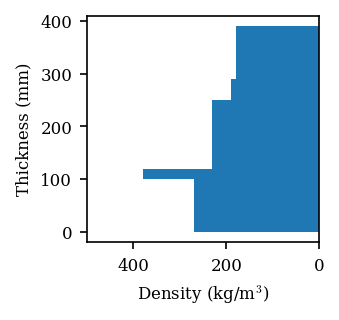

In [4]:
weac.plot.slab_profile(pst_cut_right)

### Analyze skier-induced stresses and deformations
---

In [5]:
# Example with two segements, one skier load
# (between segments 1 & 2) and no crack.

#                   |
#                   v
# +-----------------+-----------------+
# |                 |                 |
# |        1        |        2        |
# |                 |                 |
# +-----------------+-----------------+
#  |||||||||||||||||||||||||||||||||||
# --------------------------------------

In [6]:
# Input
totallength = 1e4                       # Total length (mm)
cracklength = 0                         # Crack length (mm)
inclination = 30                        # Slope inclination (°)
skierweight = 80                        # Skier weigth (kg)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. We
# can choose to analyze the situtation before a crack appears
# even if a cracklength > 0 is set by replacing the 'crack'
# key thorugh the 'uncracked' key.
seg_skier = skier.calc_segments(
    L=totallength, a=cracklength, m=skierweight)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skier = skier.assemble_and_solve(
    phi=inclination, **seg_skier)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_skier, zq_skier, xb_skier = skier.rasterize_solution(
    C=C_skier, phi=inclination, **seg_skier)

#### Visualize slab deformations (contour plot)

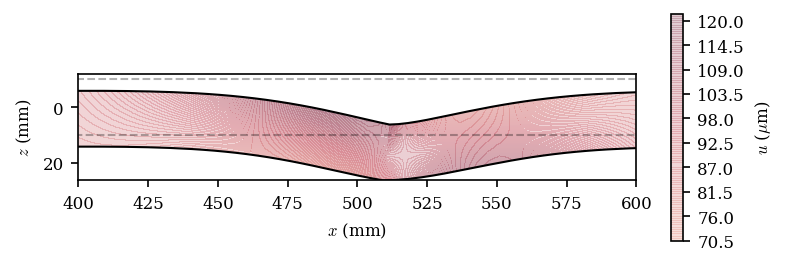

In [7]:
weac.plot.contours(skier, xq_skier, zq_skier, window=200, scale=100)

#### Plot slab displacements

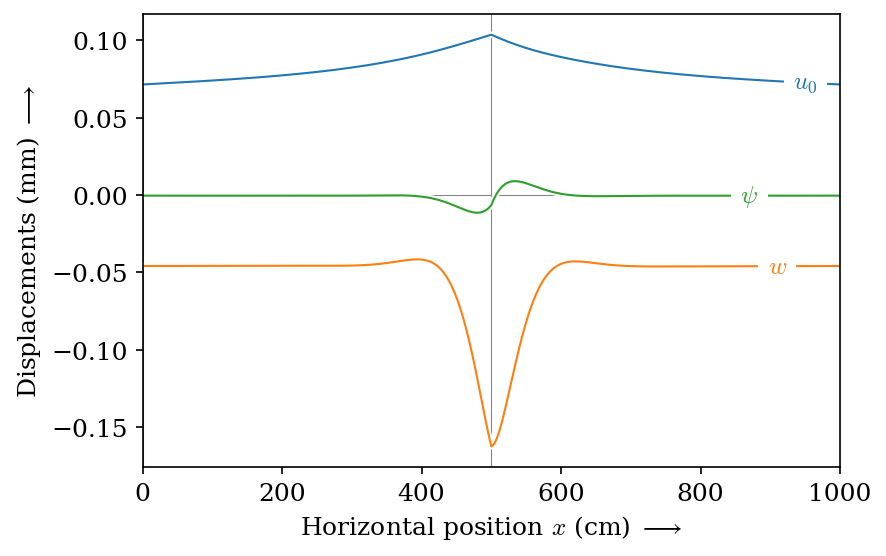

In [8]:
weac.plot.displacements(skier, x=xq_skier, z=zq_skier, **seg_skier)

#### Plot stresses

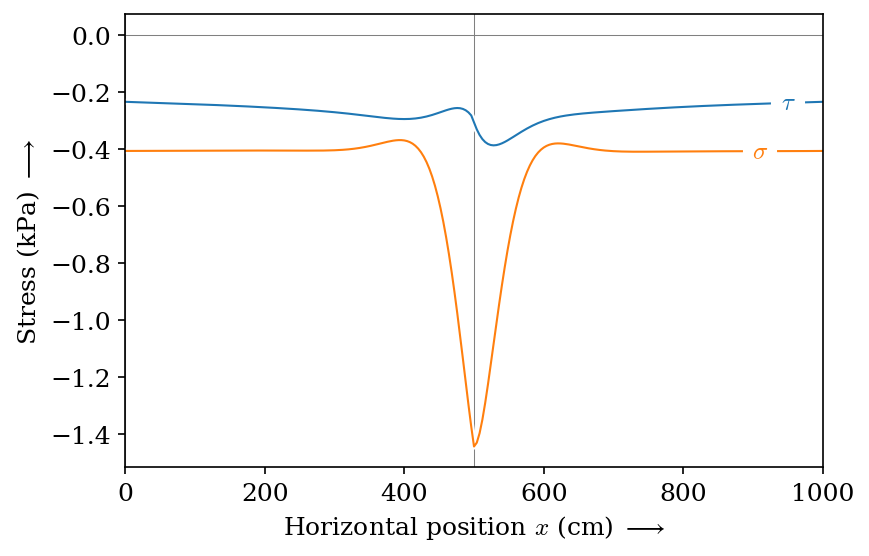

In [9]:
weac.plot.stresses(skier, x=xb_skier, z=zq_skier, **seg_skier)

### Multiple skiers
----

In [10]:
# Example with six segements, two skier loads (between
# segments 1 & 2 and 2 & 3) and a crack under segments
# 4 and 5

#           |   |
#           v   v
# +---------+---+-----+---+---+-------+
# |         |   |     |   |   |       |
# |    1    | 2 |  3  | 4 | 5 |   6   |
# |         |   |     |   |   |       |
# +---------+---+-----+---+---+-------+
#  |||||||||||||||||||         |||||||
# --------------------------------------

In [11]:
# Input
li = [5e3, 10e2, 25e2, 2e2, 7e2, 5e3]           # Beam segment lengths (mm)
ki = [True, True, True, False, False, True]     # Foundation (bedded/free = True/False)
mi = [80, 80, 0, 0, 0]                          # Skier weights [kg]
inclination = 20                                # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations,
# and position and magnitude of skier loads from inputs. If,
# in addition, a list k0 is passed to calc_segments, we may
# replace the 'crack' key by the 'nocrack' key to toggle
# between cracked (ki) and uncracked (k0) configurations.
seg_skiers = skiers_on_B.calc_segments(
    li=li, ki=ki, mi=mi)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_skiers = skiers_on_B.assemble_and_solve(
    phi=inclination, **seg_skiers)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_skiers, zq_skiers, xb_skiers = skiers_on_B.rasterize_solution(
    C=C_skiers, phi=inclination, **seg_skiers)

#### Visualize slab deformations (contour plot)

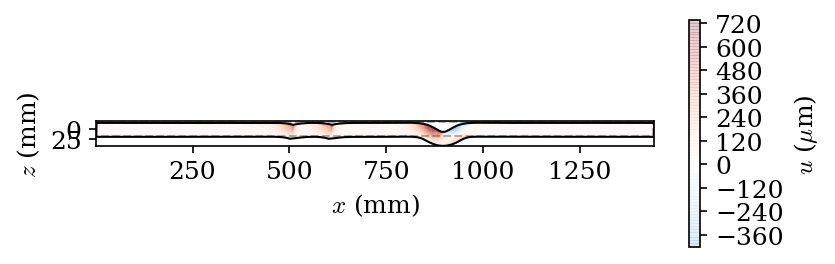

In [12]:
weac.plot.contours(skiers_on_B, xq_skiers, zq_skiers, window=1e4, scale=20)

#### Plot slab displacements

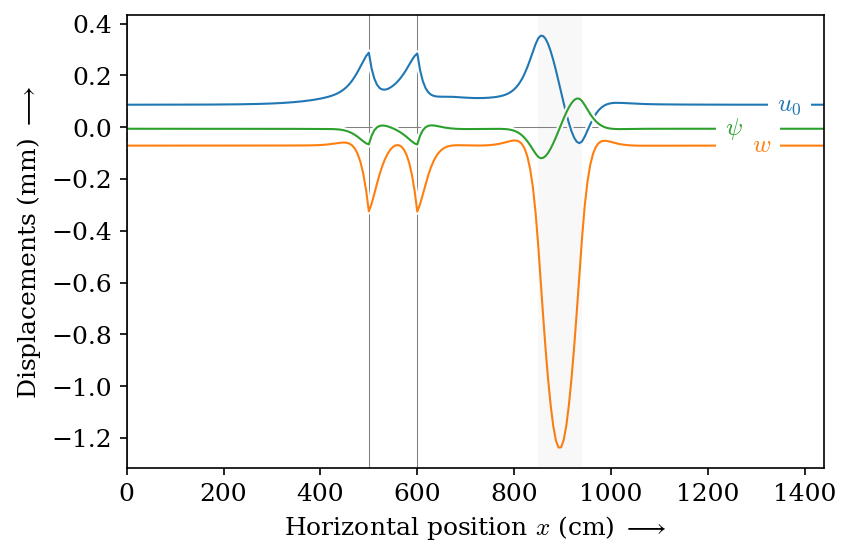

In [13]:
weac.plot.displacements(skiers_on_B, x=xq_skiers, z=zq_skiers, **seg_skiers)

#### Plot weak-layer stresses

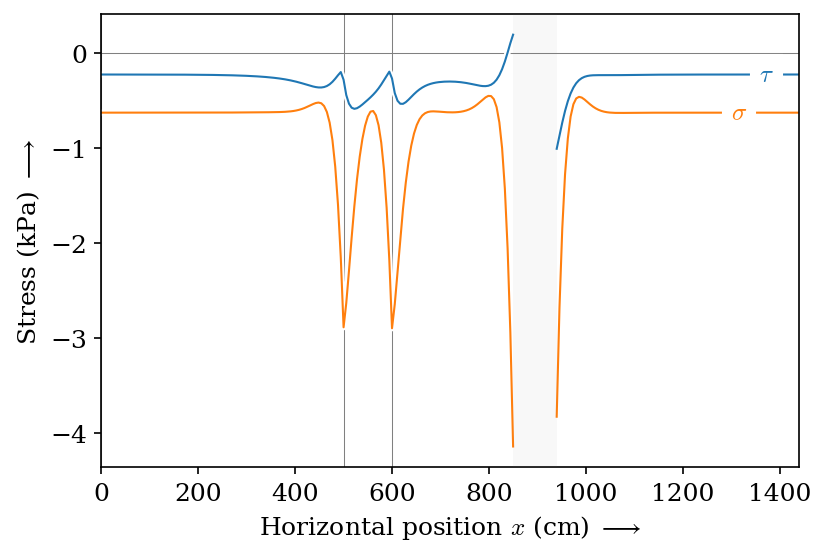

In [14]:
weac.plot.stresses(skiers_on_B, x=xb_skiers, z=zq_skiers, **seg_skiers)

### Propagation saw test
---

In [15]:
# Example with a crack cut from the right-hand side.

# +-----------------------------+-----+
# |                             |     |
# |             1               |  2  |
# |                             |     |
# +-----------------------------+-----+
#  |||||||||||||||||||||||||||||
# --------------------------------------

In [16]:
# Input
totallength = 2500                      # Total length (mm)
cracklength = 500                       # Crack length (mm)
inclination = 38                        # Slope inclination (°)

# Obtain lists of segment lengths, locations of foundations.
# We can choose to analyze the situtation before a crack
# appears even if a cracklength > 0 is set by replacing the
# 'crack' key thorugh the 'uncracked' key.
seg_pst = pst_cut_right.calc_segments(
    L=totallength, a=cracklength)['crack']

# Assemble system of linear equations and solve the
# boundary-value problem for free constants.
C_pst = pst_cut_right.assemble_and_solve(
    phi=inclination, **seg_pst)

# Prepare the output by rasterizing the solution vector at all
# horizontal positions xq. The result is returned in the form
# of the ndarray zq. Also provides xb that only contains
# x-coordinates that lie on a foundation.
xq_pst, zq_pst, xb_pst = pst_cut_right.rasterize_solution(
    C=C_pst, phi=inclination, **seg_pst)

#### Visualize slab deformations (contour plot)

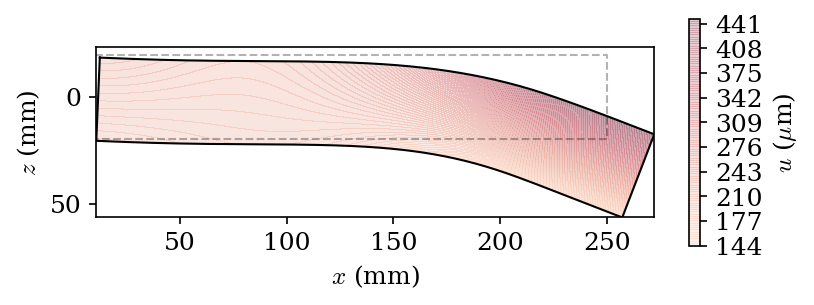

In [17]:
weac.plot.contours(pst_cut_right, xq_pst, zq_pst, scale=50)

#### Plot slab deformations

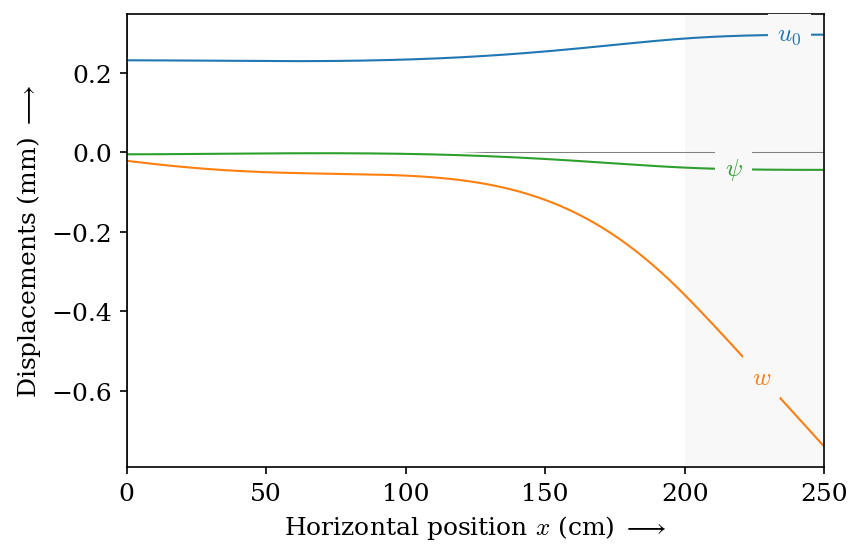

In [18]:
weac.plot.displacements(pst_cut_right, x=xq_pst, z=zq_pst, **seg_pst)

#### Plot weak-layer stresses

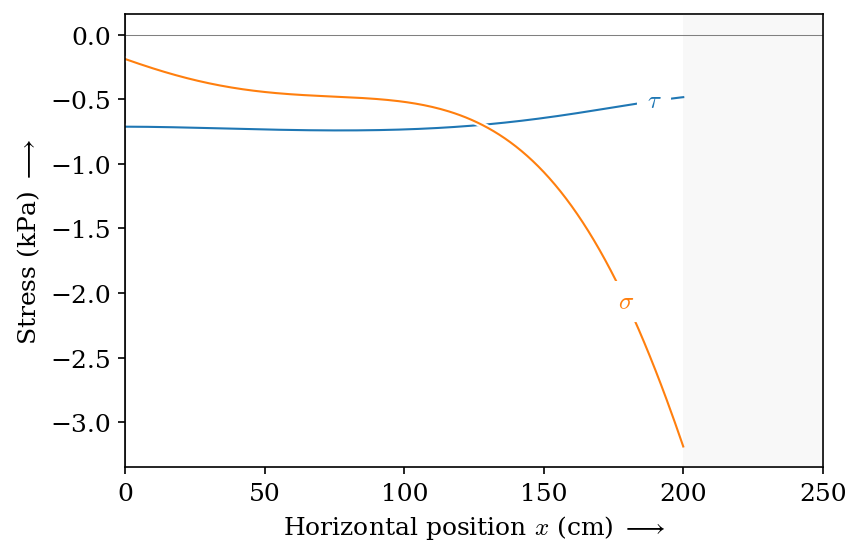

In [19]:
weac.plot.stresses(pst_cut_right, x=xb_pst, z=zq_pst, **seg_pst)

### Energy release rate in propagation saw tests
---

In [20]:
# Input
totallength = 1200                      # Total length (mm)
cracklength = 400                       # Maximum crack length (mm)
inclination = 30                        # Slope inclination (°)
n = 50                                  # Number of crack increments

# Initialize outputs and crack lengths
Gdif = np.zeros([3, n])
Ginc = np.zeros([3, n])
da = np.linspace(1e-6, cracklength, num=n)

# Loop through crack lengths
for i, a in enumerate(da):
    
    # Obtain lists of segment lengths, locations of foundations.
    seg_err = pst_cut_right.calc_segments(L=totallength, m=skierweight, a=a)
    
    # Assemble system and solve for free constants
    C0 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['nocrack'])
    C1 = pst_cut_right.assemble_and_solve(phi=inclination, **seg_err['crack'])
    
    # Compute differential and incremental energy release rates
    Gdif[:, i] = pst_cut_right.gdif(C1, inclination, **seg_err['crack'])
    Ginc[:, i] = pst_cut_right.ginc(C0, C1, inclination, **seg_err['both'])

#### Plot differential energy release rate

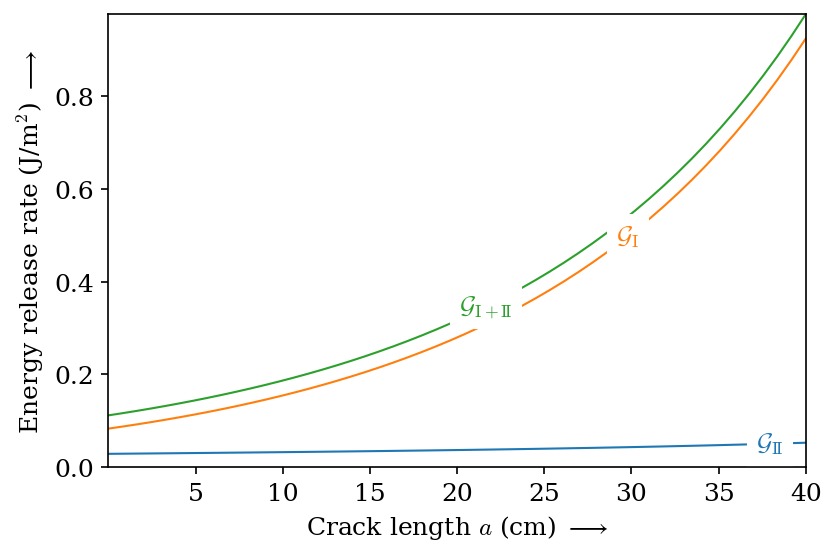

In [21]:
weac.plot.err_modes(da, Gdif, kind='dif')